In [85]:
import pandas as pd
import torch
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
import itertools
import os
import seaborn as sns
import matplotlib.pyplot as plt

from torchmetrics.classification import Accuracy, Precision, Recall, F1Score, ConfusionMatrix


from mpl_toolkits.axes_grid1 import make_axes_locatable
from SNN.models import SNNLayer
from SNN.utils import temporal_encode

In [86]:
device = torch.device("cuda")

In [87]:

# Transform to be applied on to the data immediately after loading from location.
image_size = 14
transform = transforms.Compose([
    transforms.Resize((image_size, image_size))
])

# Load and transform MNIST data
mnist_data_train = datasets.MNIST(root="data/MNIST", train=True, download=True, transform=transform)
mnist_data_test = datasets.MNIST(root="data/MNIST", train=False, download=True, transform=transform)
# mnist_data_train = datasets.FashionMNIST(root="data/MNIST", train=True, download=True, transform=transform)
# mnist_data_test = datasets.FashionMNIST(root="data/MNIST", train=False, download=True, transform=transform)
# train_size = int(0.9 * len(mnist_data_train))       # Size of the train split
# val_size = len(mnist_data_train) - train_size       # Size of the validation split



In [88]:
class CustomDataset(Dataset):
    def __init__(self, mnist_data, device=device):
        super().__init__()
        self.labels = []

        # Convert to NumPy if applying transform
        if mnist_data.transform is not None:
            # data = torch.stack([mnist_data.transform(img) for img in mnist_data.data])
            self.processed_data = mnist_data.transform(mnist_data.data).reshape((mnist_data.data.shape[0], -1)).to(device)
        else:
            self.processed_data = mnist_data.data.to(device)
        self.labels = torch.tensor(mnist_data.targets).to(device)

    def __len__(self):
        return self.processed_data.shape[0]
    
    def __getitem__(self, index):
        return self.processed_data[index], self.labels[index]
        

In [89]:
class ResourceRichReadoutLayer(nn.Module):
    def __init__(self, input_size: int):
        super(ResourceRichReadoutLayer, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)  # Batch Norm after first FC layer
        self.dropout1 = nn.Dropout(0.3)  # Dropout with 30% probability

        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)  # Batch Norm after second FC layer
        self.dropout2 = nn.Dropout(0.3)  # Dropout

        self.fc3 = nn.Linear(64, 10)
        self.softmax = nn.Softmax(dim=1)
        self.act = F.gelu

    def forward(self, x):
        x = self.act(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        x = self.act(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        x = self.fc3(x)  # Output layer (logits)
        return x


class ResourceConstraintedReadoutLayer(nn.Module):
    def __init__(self, input_size:int):
        super(ResourceConstraintedReadoutLayer, self).__init__()
        self.fc = nn.Linear(input_size, 10)
        self.activation = nn.functional.leaky_relu
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.activation(self.fc(x))
        return x

In [90]:

BATCH_SIZE = 1024


train_dataset = CustomDataset(mnist_data_train)
test_dataset = CustomDataset(mnist_data_test)


train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False)



C:\Users\adith\AppData\Local\Temp\ipykernel_7028\702354098.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(mnist_data.targets).to(device)


In [91]:

EPOCHS = 150
learning_rate = 0.0005
# learning_rate = 1e-3

# model = ResourceConstraintedReadoutLayer(image_size**2).to(device=device)
model = ResourceRichReadoutLayer(image_size**2).to(device=device)
# model = SNN(number_of_devices * NUMBER_OF_MASKS, num_classes=10).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


val_accuracy, val_precision, val_recall, val_fscore = [], [], [], []

accuracy = Accuracy(task="multiclass", num_classes=10).to(device)
precision = Precision(task="multiclass", num_classes=10, average='macro').to(device)
recall = Recall(task="multiclass", num_classes=10, average='macro').to(device)
f1_score = F1Score(task="multiclass", num_classes=10, average='macro').to(device)

confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=10).to(device)


In [92]:
for epoch in range(EPOCHS):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move to device
        # spike_train = temporal_encode(images)
        outputs = model(images.float())  # Forward pass
        # outputs = model(spike_train)
        loss = criterion(outputs, labels)  # Loss calculation
        optimizer.zero_grad()
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
    
    
    # Validation phase
    # model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images, labels
            # spike_train = temporal_encode(images)
            outputs = model(images.float())
            # outputs = model(spike_train)
            preds = outputs.argmax(dim=1)

            # Update metrics
            accuracy.update(preds, labels)
            precision.update(preds, labels)
            recall.update(preds, labels)
            f1_score.update(preds, labels)

        # Print validation metrics

        if (epoch+1)%1 == 0:
            print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}', end=" ")
            print(f'Validation - Accuracy: {accuracy.compute().item():.4f} Precision: {precision.compute().item():.4f} ', end=" ")
            print(f'Recall: {recall.compute().item():.4f} F1 Score: {f1_score.compute().item():.4f}')

        # Updating the list to save current metrics
        val_accuracy.append(accuracy.compute().item())
        val_precision.append(precision.compute().item())
        val_recall.append(recall.compute().item())
        val_fscore.append(f1_score.compute().item())

        # Reset metrics for the next epoch
        accuracy.reset()
        precision.reset()
        recall.reset()
        f1_score.reset()
        confusion_matrix.reset()

Epoch [1/150], Loss: 0.9666 Validation - Accuracy: 0.8449 Precision: 0.8448  Recall: 0.8414 F1 Score: 0.8403
Epoch [2/150], Loss: 0.5771 Validation - Accuracy: 0.8901 Precision: 0.8889  Recall: 0.8887 F1 Score: 0.8884
Epoch [3/150], Loss: 0.4258 Validation - Accuracy: 0.9100 Precision: 0.9090  Recall: 0.9089 F1 Score: 0.9088
Epoch [4/150], Loss: 0.3774 Validation - Accuracy: 0.9193 Precision: 0.9184  Recall: 0.9184 F1 Score: 0.9183
Epoch [5/150], Loss: 0.2645 Validation - Accuracy: 0.9342 Precision: 0.9335  Recall: 0.9334 F1 Score: 0.9333
Epoch [6/150], Loss: 0.2858 Validation - Accuracy: 0.9343 Precision: 0.9336  Recall: 0.9335 F1 Score: 0.9335
Epoch [7/150], Loss: 0.2265 Validation - Accuracy: 0.9416 Precision: 0.9410  Recall: 0.9409 F1 Score: 0.9409
Epoch [8/150], Loss: 0.1721 Validation - Accuracy: 0.9469 Precision: 0.9465  Recall: 0.9466 F1 Score: 0.9465
Epoch [9/150], Loss: 0.1980 Validation - Accuracy: 0.9474 Precision: 0.9470  Recall: 0.9468 F1 Score: 0.9469
Epoch [10/150], Los

In [93]:

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)
        # spike_train = temporal_encode(images)
        outputs = model(torch.tensor(images, dtype=torch.float32))
        # outputs = model(spike_train)
        _, predicted = torch.max(outputs, 1)

        # Append predictions and labels for metric calculations
        all_preds.append(predicted)
        all_labels.append(labels)


# Concatenate all predictions and labels
all_preds = torch.cat(all_preds).to(device)
all_labels = torch.cat(all_labels).to(device)

# Calculate metrics
test_accuracy = accuracy(all_preds, all_labels)
test_precision = precision(all_preds, all_labels)
test_recall = recall(all_preds, all_labels)
test_f1 = f1_score(all_preds, all_labels)
test_confusion_matrix = confusion_matrix(all_preds, all_labels)

print(f'Test Accuracy: {test_accuracy * 100:.4f}%')
print(f'Test Precision: {test_precision*100:.4f}%')
print(f'Test Recall: {test_recall*100:.4f}%')
print(f'Test F1 Score: {test_f1:.4f}')

        

Test Accuracy: 98.4400%
Test Precision: 98.4323%
Test Recall: 98.4315%
Test F1 Score: 0.9843


C:\Users\adith\AppData\Local\Temp\ipykernel_7028\896211148.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images, dtype=torch.float32))


In [94]:
x = np.argmax(val_fscore)
print(val_accuracy[x], val_precision[x], val_recall[x], val_fscore[x])

0.9764999747276306 0.976233184337616 0.9761657118797302 0.9761936068534851


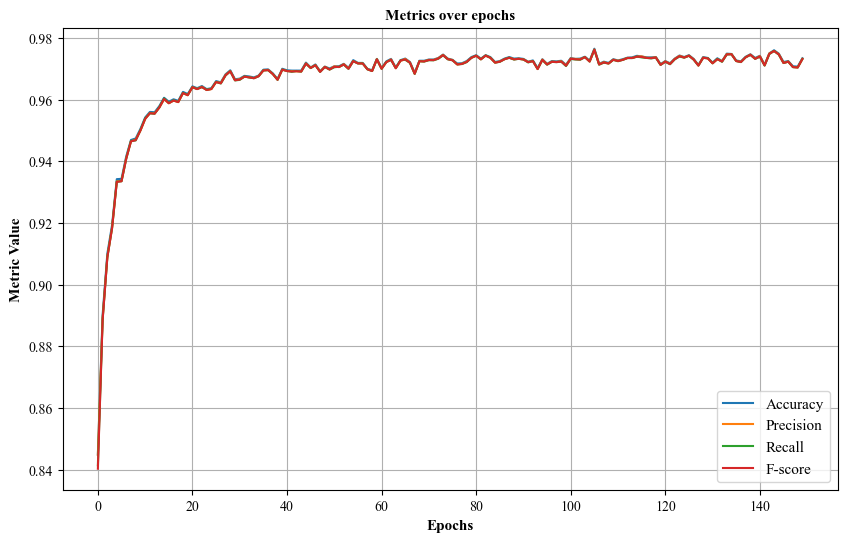

In [95]:

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.rcParams["font.family"] = "Times New Roman"

plt.plot([i for i in range(len(val_accuracy))], val_accuracy, label='Accuracy')
plt.plot([i for i in range(len(val_precision))], val_precision, label='Precision')
plt.plot([i for i in range(len(val_recall))], val_recall, label='Recall')
plt.plot([i for i in range(len(val_fscore))], val_fscore, label='F-score')



# Add title, labels, and legend
plt.title('Metrics over epochs', {"size": 11, "family": "Times New Roman", "weight": "bold"})
plt.xlabel('Epochs', {"size": 11, "family": "Times New Roman", "weight": "bold"})
plt.ylabel('Metric Value', {"size": 11, "family": "Times New Roman", "weight": "bold"})
plt.grid(True)
plt.legend(fontsize=11)  # Add legend to the plot
plt.show()

In [96]:
metrics_df = pd.DataFrame({
    "Accuracy":val_accuracy,
    "Precision":val_precision,
    "Recall":val_recall,
    "F-score":val_fscore
})

In [97]:
if isinstance(model, ResourceRichReadoutLayer):
    model_type = "no_resource_constraint"
elif isinstance(model, ResourceConstraintedReadoutLayer):
    model_type = "resource_constraint"
else:
    raise TypeError("ARMAGEDDON HERE IN MODEL TYPE")

if isinstance(mnist_data_train, datasets.MNIST):
    if image_size == 28:
        metrics_path = f"data/RC_yasir_metrics/MNIST/no_RC_{model_type}/"
    elif image_size == 20:
        metrics_path = f"data/RC_yasir_metrics/Reduced_mnist_20x20/no_RC_{model_type}/"
    elif image_size == 14:
        metrics_path = f"data/RC_yasir_metrics/Reduced_mnist_14x14/no_RC_{model_type}/"
    else:
        raise TypeError("ARMAGEDDON IN FILE PATH")
else:
    raise TypeError("ARMAGEDDON IN DATASET CLASS")

print(metrics_path)

data/RC_yasir_metrics/Reduced_mnist_14x14/no_RC_no_resource_constraint/


In [98]:
metrics_df.to_excel(metrics_path + "metrics.xlsx")

In [99]:

confusion_matrix_df = pd.DataFrame(test_confusion_matrix.cpu().numpy(), index=mnist_data_train.classes, columns=mnist_data_train.classes)

confusion_matrix_df.to_excel(metrics_path + "confusion_matrix.xlsx")